# AI Sampleset: Tonality and Phase

In [3]:
import torch as tch
import tikzplotlib
import matplotlib.pyplot as plt
import torchaudio
import IPython
import soundfile
import numpy as np

#good sample
path1 = "../sampleset/full/WDH_KICK_D#02.wav"
#terrible sample
path2 = "../sampleset/bad/THT_Kicks_21.wav"
#decent, but bad envelope
path3 = "../sampleset/bad/bad_envelope.wav"
#clicky transient
path4 = "../sampleset/full/A_Kick_09.wav"


sample1 = torchaudio.load(path1)[0][0]
sample2 = torchaudio.load(path2)[0][0]
sample3 = torchaudio.load(path3)[0][0]
sample4 = torchaudio.load(path4)[0][0]

Fs = 44100

## Instantaneous Frequency (IF) analysis

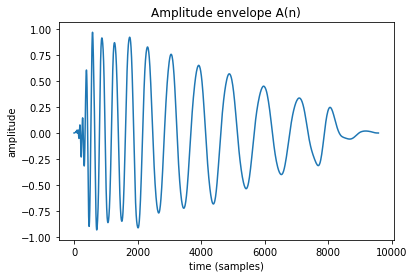

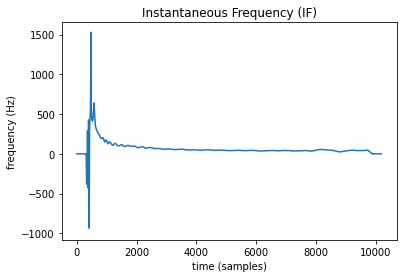

6752


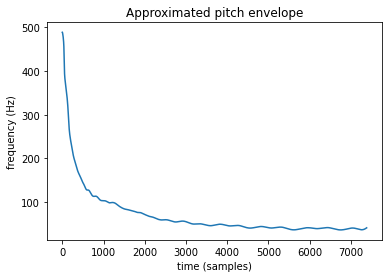

38.8749297093463

In [38]:
from scipy.signal import hilbert, find_peaks
from scipy.signal.windows import gaussian
from quality.utils import butter_lp, moving_avg

def gauss_filt(signal, N=601, alpha=2):
    win = gaussian(N, alpha)
    win = win / np.sum(win)
    return np.convolve(signal, win)

def last_peak(sample):
    pks, _ = find_peaks(sample, width=64, height=5e-2)
    return pks[len(pks)-1]
    
def hilbert_analysis(signal, plot=False):
    signal = butter_lp(signal, 500)
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    if plot:
            plt.plot(signal)
            plt.xlabel("time (samples)")
            plt.ylabel("amplitude")
            tikzplotlib.clean_figure()
            tikzplotlib.save("if0.tex", axis_width='3.2in', axis_height='2.4in')
            plt.title("Amplitude envelope A(n)")
            plt.show()
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (gauss_filt(np.diff(instantaneous_phase)) / (2.0*np.pi) * Fs)
    if plot:
            plt.plot(instantaneous_frequency)
            plt.ylabel("frequency (Hz)")
            plt.xlabel("time (samples)")
            tikzplotlib.clean_figure()
            tikzplotlib.save("if1.tex", axis_width='3.2in', axis_height='2.4in')
            plt.title("Instantaneous Frequency (IF)")
            plt.show()
    last_pk = last_peak(signal)
    pitch_env=moving_avg(instantaneous_frequency[0:last_pk],256)
    pk_pitch = np.argmax(pitch_env)
    pitch_env = pitch_env[pk_pitch:last_pk]
    argmin = np.argmin(pitch_env[0:len(pitch_env)-500])
    print(argmin)
    if(argmin >= 500):
        note_hz = np.mean(pitch_env[argmin-500:argmin+500])
    else:
        note_hz = np.mean(pitch_env[0:1000])
    if plot:
        plt.plot(pitch_env)
        plt.ylabel("frequency (Hz)")
        plt.xlabel("time (samples)")
        tikzplotlib.clean_figure()
        tikzplotlib.save("if2.tex", axis_width='3.2in', axis_height='2.4in')
        plt.title("Approximated pitch envelope")
        plt.show()
    return note_hz
    
hilbert_analysis(sample1, True)

## Converting to notes
Below a conversion between the above found frequency in Hz and a note in the equal temperament scale.

In [5]:
from math import log2

#Equal temperament, A4 = 440 Hz
note_names = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
note_hz = [ 16.35, 17.32, 18.35, 19.45, 20.60, 21.83, 23.12, 24.50, 25.96, 27.50, 29.14, 30.87, 
           32.70, 34.65, 36.71, 38.89, 41.20, 43.65, 46.25, 49.00, 51.91, 55.00, 58.27, 61.74, 
           65.41, 69.30, 73.42, 77.78, 82.41, 87.31, 92.50, 98.00, 103.83, 110.00, 116.54, 
           123.47, 130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185.00, 196.00, 207.65, 
           220.00, 233.08, 246.94, 261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 
           392.00, 415.30, 440.00, 466.16, 493.88, 523.25, 554.37, 587.33, 622.25, 659.25, 
           698.46, 739.99, 783.99, 830.61, 880.00, 932.33, 987.77, 1046.50, 1108.73, 1174.66, 
           1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760.00, 1864.66, 1975.53, 
           2093.00, 2217.46, 2349.32, 2489.02, 2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 
           3520.00, 3729.31, 3951.07, 4186.01, 4434.92, 4698.63, 4978.03, 5274.04, 5587.65, 
           5919.91, 6271.93, 6644.88, 7040.00, 7458.62, 7902.13 ]

def nearest_index(freq):
    """Find the index of the nearest note in the array"""
    for i in range(1, len(note_hz)):
        if(freq <= note_hz[i]):
            if(freq - note_hz[i-1] < note_hz[i] - freq):
                return i-1
            else:
                return i

def note_dist(f1, f2):
    """Calculate note distance in cents"""
    return 1200 * log2(f1 / f2)

def display_note(freq):
    """Find the nearest note and return its name, plus the offset"""
    idx = nearest_index(freq)
    reg = idx // 12
    return note_names[idx % 12] + str(reg) + f" {note_dist(freq, note_hz[idx]):.2f}"

display_note(38.8749297093463)

'D#1 -0.67'

Spot on! The kick sample was labeled as D#, and the algorithm estimates it to be less than a cent below that.

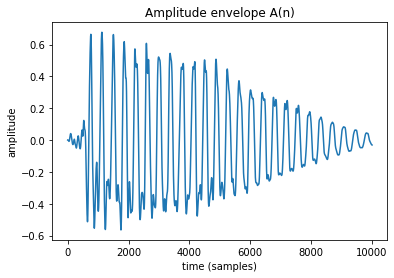

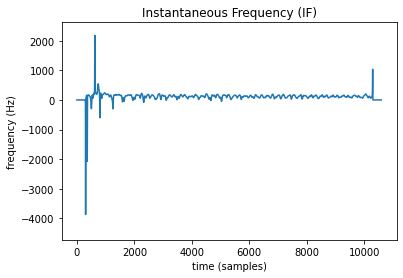

972


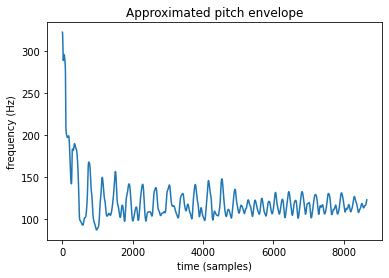

114.38428298272592

In [41]:
hilbert_analysis(torchaudio.load("../sampleset/fake/piano_short.wav")[0][0].numpy()[0:10000], True)

In [7]:
import os

def get_note(file):
    sample = torchaudio.load("../sampleset/full/" + file)[0][0]
    return hilbert_analysis(sample)

for f in os.listdir("C:/Users/damen/Nextcloud/Music/Samples/Packs/Black Octopus Sound - Wicked Drum Hits/Kicks Tuned"):
    print(f, get_note(f))

WDH_KICK_A#01.wav 58.9907424486355
WDH_KICK_A#02.wav 60.36828856733792
WDH_KICK_A#03.wav 58.420028417471954
WDH_KICK_A01.wav 55.57546004683075
WDH_KICK_A02.wav 60.83178553274068
WDH_KICK_A03.wav 55.82515369200432
WDH_KICK_A04.wav 55.481356492616996
WDH_KICK_A05.wav 56.36054966883539
WDH_KICK_A06.wav 57.12624390690364
WDH_KICK_A07.wav 55.226101435067086
WDH_KICK_B01.wav 64.93799963540482
WDH_KICK_B02.wav 63.597573532922716
WDH_KICK_B03.wav 69.04079946693865
WDH_KICK_C01.wav 70.60334882026265
WDH_KICK_C02.wav 35.4863280844723
WDH_KICK_C03.wav 66.39660042287724
WDH_KICK_D#01.wav 40.47937490796914
WDH_KICK_D#02.wav 38.8749297093463
WDH_KICK_D#03.wav 40.05348948918037
WDH_KICK_D#04.wav 39.545648076623344
WDH_KICK_D01.wav 37.49015406995167
WDH_KICK_D02.wav 48.64970210188086
WDH_KICK_D03.wav 40.166823094897836
WDH_KICK_E01.wav 42.408488487299806
WDH_KICK_E02.wav 42.32317734573196
WDH_KICK_E03.wav 43.35240940886944
WDH_KICK_E04.wav 43.04002373547957
WDH_KICK_F#01.wav 46.18688671587485
WDH_KICK

## Histogram over entire dataset

In [6]:
hzs = []

for f in os.listdir('../sampleset/full'):
    sample = torchaudio.load("../sampleset/full/" + f)[0][0]
    hz = hilbert_analysis(sample)
    if hz >= 100:
        print(f)
    hzs.append(hz)

spectra_kick_oneshot_re20_A.wav


C:\Users\damen\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\damen\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


WDH_KICK007.wav
WDH_KICK019.wav
WDH_KICK021.wav
WDH_KICK029.wav
WDH_KICK076.wav
WDH_KICK082.wav


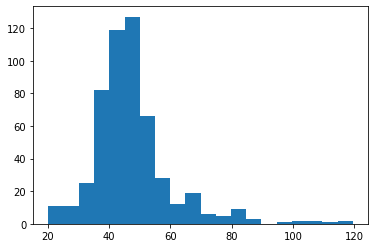

In [7]:
plt.rcParams["hist.bins"] = 20
plt.hist(hzs)
plt.show()

## Quality measure based on fundamental frequency

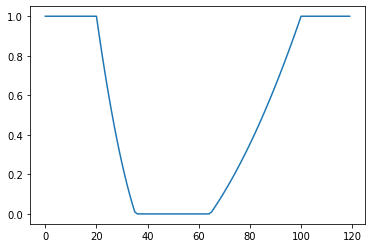

In [8]:
from scipy.interpolate import interp1d

def frq_qual(hz):
    if hz <= 20:
        return 1
    elif hz > 100:
        return 1
    else:
        interp = interp1d([20, 35, 65, 100], [1, 0.01, 0.01, 1], kind='quadratic')
        return max(0,interp(hz))

plt.plot([frq_qual(x) for x in np.arange(0,120)])
plt.show()

# Harmonic Overtones

The following 3 graphs are meant to illustrate what we are going to try to detect in this part. 
The first step in the harmonic series is an octave, so if any overtones smaller than an octave are present in the signal, 
this should get a bad quality.

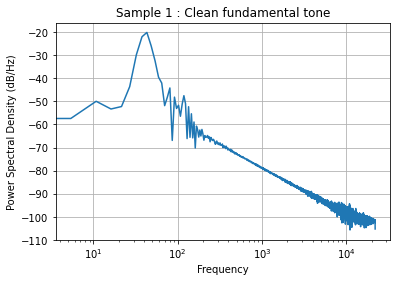

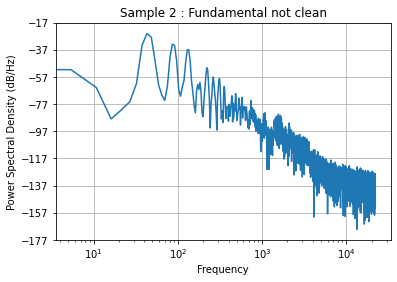

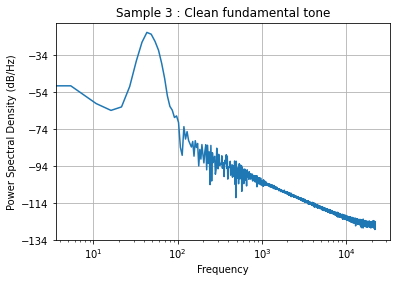

In [8]:
plt.psd(sample1[2000:last_peak(sample1)], Fs=44100, detrend='linear', NFFT=8192)
plt.title("Sample 1 : Clean fundamental tone")
plt.xscale('log')
plt.show()
plt.psd(sample2[2000:last_peak(sample2)], Fs=44100, detrend='linear', NFFT=8192)
plt.title("Sample 2 : Fundamental not clean")
plt.xscale('log')
plt.show()
plt.psd(sample3[2000:last_peak(sample3)], Fs=44100, detrend='linear', NFFT=8192)
plt.title("Sample 3 : Clean fundamental tone")
plt.xscale('log')
plt.show()

### Same computation using scipy

[0.00000000e+00 5.38330078e+00 1.07666016e+01 ... 2.20392334e+04
 2.20446167e+04 2.20500000e+04]


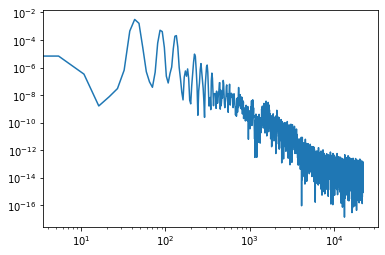

In [16]:
from scipy.signal import welch
from scipy.signal import find_peaks

freqs, psd = welch(sample2[2000:last_peak(sample2)], nfft = 8192, fs = 44100, detrend='linear', nperseg=8192)

print(freqs)
plt.plot(freqs,psd)
plt.yscale('log')
plt.xscale('log')
plt.show()

Removing the log scale on the y axis gives a more direct image of what we are looking for. 
Use peak detection to find the second peak of the signal.

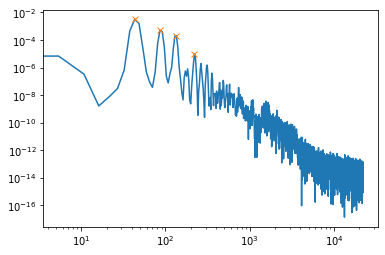

In [17]:
peaks, _ = find_peaks(psd, height=1e-6, prominence=2e-6)

plt.plot(freqs,psd)
plt.plot(freqs[peaks], psd[peaks], "x")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [18]:
ratio1 = freqs[peaks[1]] / freqs[peaks[0]]
ratio2 = freqs[peaks[2]] / freqs[peaks[0]]
ratio2 = freqs[peaks[2]] / freqs[peaks[0]]
print(ratio1, ratio2)

2.0 3.125


So from this analysis it appears the first peak corresponds to the first overtone, which is an octave above the fundamental. That is good, 
but how loud it is, is definitely bad.
Furthermore, the second peak is not an overtone, it is 3.125 times higher than the fundamental, whereas the second overtone should be exactly 3 times higher, a fifth above the first overtone. 

If $V_i$ is the loudness of the i-th harmonic, The *Total Harmonic Distortion (THD)* is defined as

$$\text{THD} = \frac{\sqrt{V_2^2 + V_3^2 + \dots}}{V_1}$$

Clearly in this case we are not just dealing with "harmonic" distortion. There is also lots of noise and there seem to be clear inharmonic peaks.
There is also a notion of *Total Harmonic Distortion plus Noise (THD+N)*, which is calculated by removing only the fundamental frequency, for instance by means of a notch filter, and comparing the RMS values of the resulting signals. However, we are not opposed to noise in this case, as we are not evaluating a LTE system. We just want to measure how the first few peaks relate to the fundamental. In particular, we want to punish peaks that are inharmonic. So, we define the following measurement, call it *Inharmonic Distortion*:

$$\text{IHD} = \frac{\sqrt{w_2 P_2^2 + w_3 P_3^2 + \dots}}{P_1}$$

where $P_i$ is the volume of the i-th detected peak in the PSD, and $w_i$ is defined as:

$$w_i =
    \begin{cases}
        1 & & \text{if } f_i / f_1 \in \mathbb{Z}  \\
        q & & \text{if } f_i / f_1 = n + \frac{p}{q}
    \end{cases}$$
   
In the above example, $w_2$ would be equal to $8$, as $3.125 = 3 + \frac{1}{8}$, ofcourse $\frac{p}{q}$ should be written in lowest term.
The intuition for this is that as the fraction that describes the relationship between two frequencies becomes more complicated, the interval is perceived as more dissonant. 

In [19]:
print(freqs[peaks[0]:peaks[2]+1])

[ 43.06640625  48.44970703  53.83300781  59.21630859  64.59960938
  69.98291016  75.36621094  80.74951172  86.1328125   91.51611328
  96.89941406 102.28271484 107.66601562 113.04931641 118.43261719
 123.81591797 129.19921875 134.58251953]


In [20]:
from math import log2

log2(psd[peaks[0]]) / log2(psd[peaks[1]])

0.7618216343840529

In [29]:
def overtones(sample, pr=2e-9, w=1.5, h=1e-9, savefig=None):
    end = last_peak(sample)
    start = end // 5
    sample = sample[start:end]
    freqs, psd = welch(sample, nfft = 2*8192, fs = 44100, detrend='linear', nperseg=min(8192, len(sample)))
    print(freqs[0:100])
    peaks, _ = find_peaks(psd, height=h, prominence=pr, width=w)
    f1 = find_fund(psd, peaks)
    plt.plot(freqs,psd)
    plt.plot(freqs[peaks[f1:]], psd[peaks[f1:]], "x")
    plt.xscale('log')
    plt.yscale('log')
    if savefig is not None:
        plt.ylabel('Spectral Density')
        plt.xlabel('Frequency (Hz)')
        tikzplotlib.clean_figure()
        tikzplotlib.save(savefig, axis_width='3.52in', axis_height='2.64in')
    plt.show()
    return freqs[peaks], psd[peaks]

In [22]:
d1, d2= overtones(sample5)

NameError: name 'sample5' is not defined

In [23]:
from fractions import Fraction
from math import floor

def w(ratio):
    r = ratio - floor(ratio)
#     if ratio < 3:
#         r = round(r,1)
    f = Fraction(r).limit_denominator(1000)
    return f.denominator

def find_fund(psd, peaks):
    return np.argmax(psd[peaks])

def IHD(sample, v=False, h=1e-9, pr=2e-9, wd=1.25):
    end = last_peak(sample)
    start = end // 5
    sample = sample[start:end]
    freqs, psd = welch(sample, nfft = 2*8192, fs = 44100, detrend='linear', nperseg=min(2*8192, len(sample)))
    peaks, _ = find_peaks(psd, height=h, prominence=pr, width=wd)
    f1 = find_fund(psd, peaks)
    fund = freqs[peaks[f1]]
    ratios = freqs[peaks[f1+1:]] / fund
    weights = list(map(w, ratios))
    if v:
        print(fund)
        print(ratios, weights)
    return np.sqrt(np.sum(psd[peaks[f1+1:]]**2)) / psd[peaks[f1]]

[  0.           2.69165039   5.38330078   8.07495117  10.76660156
  13.45825195  16.14990234  18.84155273  21.53320312  24.22485352
  26.91650391  29.6081543   32.29980469  34.99145508  37.68310547
  40.37475586  43.06640625  45.75805664  48.44970703  51.14135742
  53.83300781  56.5246582   59.21630859  61.90795898  64.59960938
  67.29125977  69.98291016  72.67456055  75.36621094  78.05786133
  80.74951172  83.44116211  86.1328125   88.82446289  91.51611328
  94.20776367  96.89941406  99.59106445 102.28271484 104.97436523
 107.66601562 110.35766602 113.04931641 115.7409668  118.43261719
 121.12426758 123.81591797 126.50756836 129.19921875 131.89086914
 134.58251953 137.27416992 139.96582031 142.6574707  145.34912109
 148.04077148 150.73242188 153.42407227 156.11572266 158.80737305
 161.49902344 164.19067383 166.88232422 169.57397461 172.265625
 174.95727539 177.64892578 180.34057617 183.03222656 185.72387695
 188.41552734 191.10717773 193.79882812 196.49047852 199.18212891
 201.8737793

C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:613: RuntimeWarning: divide by zero encountered in log10
  xData = np.log10(xData)
C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:1296: RuntimeWarning: invalid value encountered in matmul
  Lambda[id_detA, 0] = (rhs[id_detA, :] @ Rotate @ (X4 - X3).T) / detA[id_detA]
C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:1299: RuntimeWarning: invalid value encountered in matmul
  -(X2[id_detA, :] - X1[id_detA, :]) @ Rotate * rhs[id_detA, :], axis=1
C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:1285: RuntimeWarning: invalid value encountered in multiply
  detA = -(X2[:, 0] - X1[:, 0]) * (X4[1] - X3[1]) + (X2[:, 1] - X1[:, 1]) * (


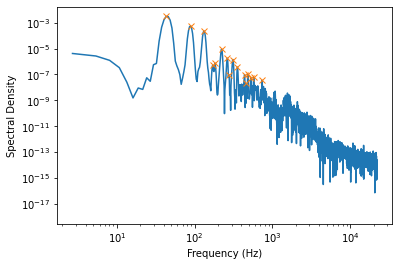

[  0.           2.69165039   5.38330078   8.07495117  10.76660156
  13.45825195  16.14990234  18.84155273  21.53320312  24.22485352
  26.91650391  29.6081543   32.29980469  34.99145508  37.68310547
  40.37475586  43.06640625  45.75805664  48.44970703  51.14135742
  53.83300781  56.5246582   59.21630859  61.90795898  64.59960938
  67.29125977  69.98291016  72.67456055  75.36621094  78.05786133
  80.74951172  83.44116211  86.1328125   88.82446289  91.51611328
  94.20776367  96.89941406  99.59106445 102.28271484 104.97436523
 107.66601562 110.35766602 113.04931641 115.7409668  118.43261719
 121.12426758 123.81591797 126.50756836 129.19921875 131.89086914
 134.58251953 137.27416992 139.96582031 142.6574707  145.34912109
 148.04077148 150.73242188 153.42407227 156.11572266 158.80737305
 161.49902344 164.19067383 166.88232422 169.57397461 172.265625
 174.95727539 177.64892578 180.34057617 183.03222656 185.72387695
 188.41552734 191.10717773 193.79882812 196.49047852 199.18212891
 201.8737793

C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:613: RuntimeWarning: divide by zero encountered in log10
  xData = np.log10(xData)
C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:1296: RuntimeWarning: invalid value encountered in matmul
  Lambda[id_detA, 0] = (rhs[id_detA, :] @ Rotate @ (X4 - X3).T) / detA[id_detA]
C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:1299: RuntimeWarning: invalid value encountered in matmul
  -(X2[id_detA, :] - X1[id_detA, :]) @ Rotate * rhs[id_detA, :], axis=1
C:\Users\damen\anaconda3\lib\site-packages\tikzplotlib\_cleanfigure.py:1285: RuntimeWarning: invalid value encountered in multiply
  detA = -(X2[:, 0] - X1[:, 0]) * (X4[1] - X3[1]) + (X2[:, 1] - X1[:, 1]) * (


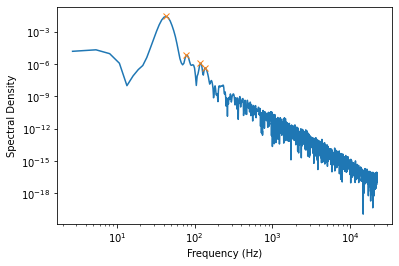

0.19329332
0.00023526762


In [30]:
overtones(sample2, h=1e-9, pr=2e-8, w=1.5, savefig="ihd_bad.tex")
overtones(sample4, h=1e-9, pr=2e-8, w=1.5, savefig="ihd_good.tex")
print(IHD(sample2))
print(IHD(sample4))

In [31]:
sin_signal = np.sin(0.005 * np.arange(0,8800))
print(IHD(sin_signal))
2e-4

4.062454323018145e-06


0.0002

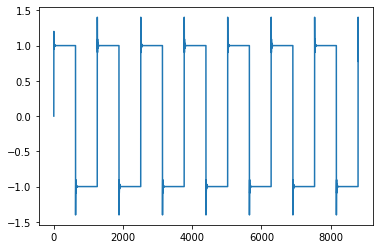

[  0.           2.69165039   5.38330078   8.07495117  10.76660156
  13.45825195  16.14990234  18.84155273  21.53320312  24.22485352
  26.91650391  29.6081543   32.29980469  34.99145508  37.68310547
  40.37475586  43.06640625  45.75805664  48.44970703  51.14135742
  53.83300781  56.5246582   59.21630859  61.90795898  64.59960938
  67.29125977  69.98291016  72.67456055  75.36621094  78.05786133
  80.74951172  83.44116211  86.1328125   88.82446289  91.51611328
  94.20776367  96.89941406  99.59106445 102.28271484 104.97436523
 107.66601562 110.35766602 113.04931641 115.7409668  118.43261719
 121.12426758 123.81591797 126.50756836 129.19921875 131.89086914
 134.58251953 137.27416992 139.96582031 142.6574707  145.34912109
 148.04077148 150.73242188 153.42407227 156.11572266 158.80737305
 161.49902344 164.19067383 166.88232422 169.57397461 172.265625
 174.95727539 177.64892578 180.34057617 183.03222656 185.72387695
 188.41552734 191.10717773 193.79882812 196.49047852 199.18212891
 201.8737793

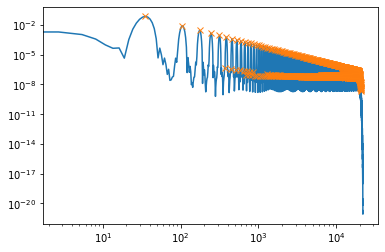

34.991455078125
[  3.           5.           7.           9.          10.46153846
  11.          12.53846154  13.          14.53846154  15.07692308
  15.76923077  16.53846154  17.07692308  17.76923077  18.53846154
  19.07692308  19.76923077  20.53846154  21.07692308  21.76923077
  22.53846154  23.07692308  23.76923077  24.53846154  25.07692308
  25.76923077  26.53846154  27.07692308  27.76923077  28.53846154
  29.07692308  29.76923077  31.07692308  31.84615385  33.07692308
  33.84615385  34.53846154  35.07692308  35.84615385  36.53846154
  37.07692308  37.84615385  38.53846154  39.07692308  39.84615385
  40.53846154  41.15384615  41.84615385  42.53846154  43.15384615
  43.84615385  44.53846154  45.15384615  45.84615385  46.61538462
  47.15384615  47.84615385  48.61538462  49.15384615  49.84615385
  50.61538462  51.15384615  51.84615385  52.61538462  53.15384615
  53.84615385  54.61538462  55.15384615  55.84615385  56.61538462
  57.15384615  57.84615385  58.61538462  59.15384615  59.846

0.12355419422343945

In [173]:
from quality.utils import butter_lp

def sqrify(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

sqr_signal = butter_lp(list(map(sqrify, sin_signal)), 20000)

plt.plot(sqr_signal)
plt.show()

overtones(sqr_signal)
IHD(sqr_signal, True)

wa_evolve_kick_65.wav
wa_evolve_kick_94.wav
WDH_KICK013.wav


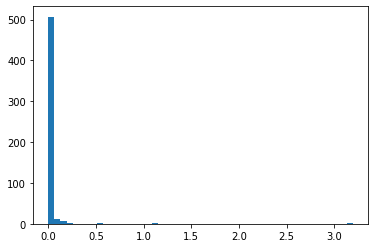

In [115]:
ihds = []

for f in os.listdir('../sampleset/full'):
    sample = torchaudio.load("../sampleset/full/" + f)[0][0]
    ih = IHD(sample, v=False)
    if ih >= .5:
        print(f)
    ihds.append(ih)

plt.rcParams["hist.bins"] = 50
plt.hist(ihds)
plt.show()

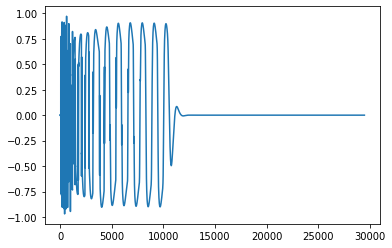

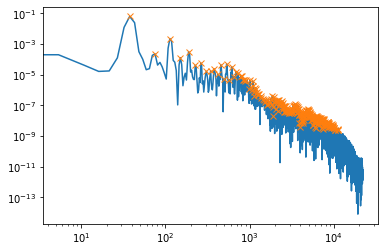

0.03682661544025011

In [120]:
k_hardstyle = torchaudio.load("../sampleset/full/spectra_kick_oneshot_hardstyle.wav")[0][0]
plt.plot(k_hardstyle)
plt.show()

         
overtones(k_hardstyle, w=1.25)
IHD(k_hardstyle,wd=1.25)

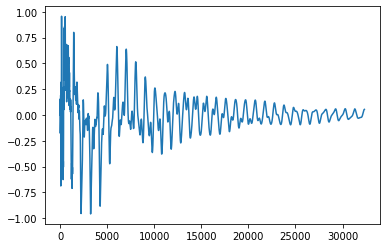

[  0.           5.38330078  10.76660156  16.14990234  21.53320312
  26.91650391  32.29980469  37.68310547  43.06640625  48.44970703
  53.83300781  59.21630859  64.59960938  69.98291016  75.36621094
  80.74951172  86.1328125   91.51611328  96.89941406 102.28271484]


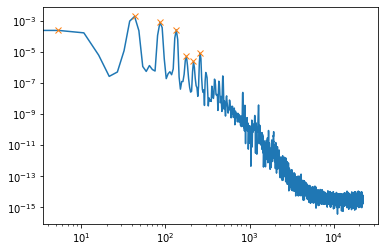

[2.    3.125 4.125 5.    6.   ] [1, 8, 8, 1, 1]


0.5810128505409068

In [29]:
k_hardstyle = torchaudio.load("../sampleset/bad/Collider Sub Kick 01.wav")[0][0]
k_lpk = last_peak(k_hardstyle)

plt.plot(k_hardstyle[0:k_lpk])
plt.show()

         
overtones(k_hardstyle[0:k_lpk])
IHD(k_hardstyle[0:k_lpk])

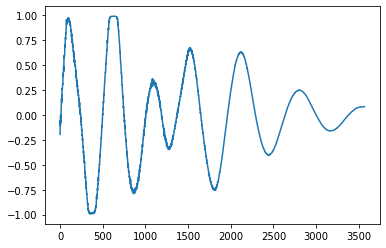

[  0.           2.69165039   5.38330078   8.07495117  10.76660156
  13.45825195  16.14990234  18.84155273  21.53320312  24.22485352
  26.91650391  29.6081543   32.29980469  34.99145508  37.68310547
  40.37475586  43.06640625  45.75805664  48.44970703  51.14135742
  53.83300781  56.5246582   59.21630859  61.90795898  64.59960938
  67.29125977  69.98291016  72.67456055  75.36621094  78.05786133
  80.74951172  83.44116211  86.1328125   88.82446289  91.51611328
  94.20776367  96.89941406  99.59106445 102.28271484 104.97436523
 107.66601562 110.35766602 113.04931641 115.7409668  118.43261719
 121.12426758 123.81591797 126.50756836 129.19921875 131.89086914
 134.58251953 137.27416992 139.96582031 142.6574707  145.34912109
 148.04077148 150.73242188 153.42407227 156.11572266 158.80737305
 161.49902344 164.19067383 166.88232422 169.57397461 172.265625
 174.95727539 177.64892578 180.34057617 183.03222656 185.72387695
 188.41552734 191.10717773 193.79882812 196.49047852 199.18212891
 201.8737793

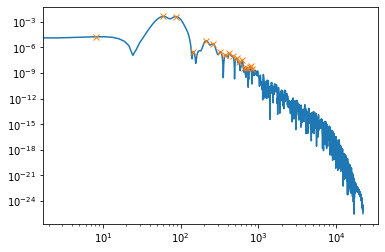

59.21630859375
[ 1.45454545  2.45454545  3.59090909  4.36363636  5.45454545  6.36363636
  7.13636364  7.90909091  8.86363636  9.45454545 10.40909091 11.13636364
 12.         13.04545455 13.54545455 14.13636364] [11, 11, 22, 11, 11, 11, 22, 11, 22, 11, 22, 22, 1, 22, 11, 22]


0.9725669050873635

In [179]:
k_hardstyle = torchaudio.load("../sampleset/full/WDH_KICK013.wav")[0][0]
k_lpk = last_peak(k_hardstyle)

plt.plot(k_hardstyle[900:k_lpk])
plt.show()

from quality.utils import butter_lp

k_hardstyle = butter_lp(k_hardstyle, 1000)

overtones(k_hardstyle, )
IHD(k_hardstyle, v=True)

In [155]:
w(round(1.454545,1))

2

In [159]:
hilbert_analysis(k_hardstyle)

62.53834679960362